# Results
In this notebook we will learn the following about the Results class returned a Benchmark evaluation:
1. **Result Creation**: How to create Results from a Benchmark and Learners.
2. **Result Plotting**: How to create plots of the learners that were evaluted by a benchmark
3. **Result Saving/Loading**: How to save and load results to and from disk
4. **Result to Pandas**: How to turn Result into a collection of Pandas dataframes for more in-depth analysis

## Result Creation

**Results** are created whenever Learners are evaluated on a Benchmark. Below is a simple example of this:

In [1]:
from coba.simulations import ValidationSimulation
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

result = Benchmark([ValidationSimulation(1000)]).evaluate([RandomLearner(), VowpalLearner(epsilon=0.1)])

2021-06-25 18:37:59 Processing chunk...
2021-06-25 18:37:59   * Creating source 0 from ValidationSimulation(cf=True,af=True,seed=1000)... (0.0 seconds)
2021-06-25 18:37:59   * Creating simulation 0 from source 0... (0.0 seconds)
2021-06-25 18:38:00   * Evaluating learner 1 on Simulation 0... (0.36 seconds)
2021-06-25 18:38:00   * Evaluating learner 0 on Simulation 0... (0.04 seconds)


## Result Plotting

The **Result** class is capable of creating two separate plots: 1) `plot_learners` and `plot_shuffles`. 

### Plot Learners
Perhaps the most straightforward question after running a Benchmark is asking which Learners performed best.

To answer this question the **Result** has a `plot_learners` method.

2021-08-16 15:01:46 Processing chunk...
2021-08-16 15:01:46   * Creating source 0 from Validation... (0.0 seconds) (completed)
2021-08-16 15:01:46   * Creating simulation 0 from source 0... (0.0 seconds) (completed)
2021-08-16 15:01:46   * Calculating Simulation 0 statistics... (0.05 seconds) (completed)
2021-08-16 15:01:46   * Evaluating learner 0 on Simulation 0... (0.03 seconds) (completed)
2021-08-16 15:01:46   * Evaluating learner 1 on Simulation 0... (0.38 seconds) (completed)
2021-08-16 15:01:46   * Creating simulation 1 from source 0... (0.0 seconds) (completed)
2021-08-16 15:01:46   * Calculating Simulation 1 statistics... (0.03 seconds) (completed)
2021-08-16 15:01:46   * Evaluating learner 0 on Simulation 1... (0.03 seconds) (completed)
2021-08-16 15:01:47   * Evaluating learner 1 on Simulation 1... (0.38 seconds) (completed)
2021-08-16 15:01:47   * Creating simulation 2 from source 0... (0.0 seconds) (completed)
2021-08-16 15:01:47   * Calculating Simulation 2 statistics...

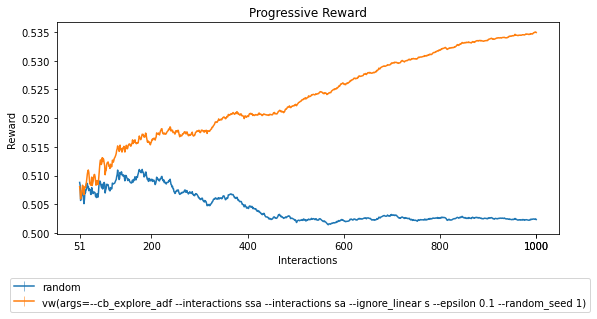

In [16]:
from coba.simulations import ValidationSimulation
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

result = Benchmark([ValidationSimulation(1000)], shuffle=[1,2,3,4]).evaluate([RandomLearner(), VowpalLearner(epsilon=0.1)])

result.plot_learners()

The `plot_learners` method has many arguments which allow customization of the plot.
```
Args:
    source_pattern: The pattern to match when determining which simulations to include in the plot. The "source" 
        matched against is either the "source" column in the simulations table or the first item in the list in 
        the simulation 'pipes' column. The simulations can be seen most easily by Result.simulations.to_pandas().
    learner_pattern: The pattern to match against the 'full_name' column in learners to determine which learners
        to include in the plot. In the case of multiple matches only the last match is kept. The learners table in
        Result can be examined via result.learners.to_pandas().
    span: In general this indicates how many previous evaluations to average together. In practice this works
        identically to ewm span value in the Pandas API. Additionally, if span equals None then all previous 
        rewards are averaged together and that value is plotted. Compare this to span = 1 WHERE only the current 
        reward is plotted for each interaction.
    start: Determines at which interaction the plot will start at. If start is greater than 1 we assume start is
        an interaction index. If start is less than 1 we assume start is the percent of interactions to skip
        before starting the plot.
    err_every: Determines frequency of bars indicating the standard deviation of the population should be drawn. 
        Standard deviation gives a sense of how well the plotted average represents the underlying distribution. 
        Standard deviation is most valuable when plotting against multiple simulations. If plotting against a single 
        simulation standard error may be a more useful indicator of confidence. The value for sd_every should be
        between 0 to 1 and will determine how frequently the standard deviation bars are drawn.
    err_type: Determines what the error bars are. Valid types are `None`, 'se', and 'sd'. If err_type is None then 
        plot will use SEM when there is only one source simulation otherwise it will use SD. Otherwise plot will
        display the standard error of the mean for 'se' and the standard deviation for 'sd'.
```

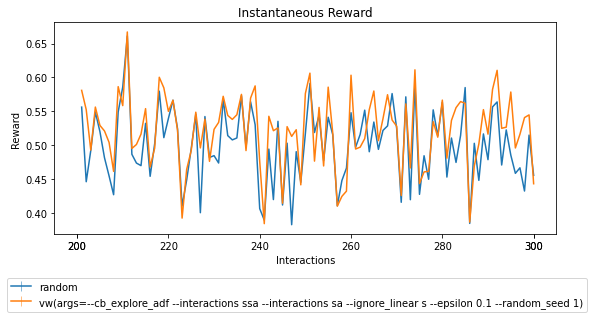

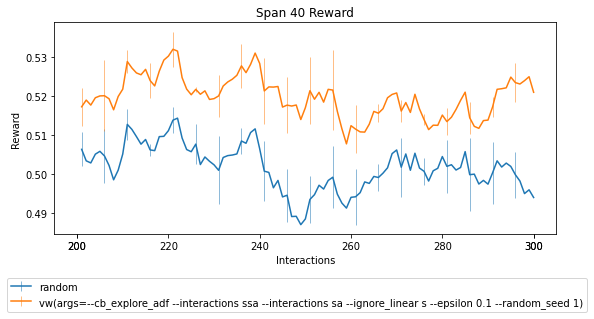

In [17]:
result.plot_learners(xlim=(200,300), span=1 , err=None)
result.plot_learners(xlim=(200,300), span=40, err='se')

## Simulations from Scratch

The final, and most involved method, for creating new simulations in Coba is to create your own from scratch. This might be needed if you need to ingest a format that Coba doesn't already support. Or maybe you need your simulation to track some internal state between interactions. By creating your own Simulation there really is no limit to the functionality employed. In order to make your own simulation you'll first need to know a few simple classes/interfaces. We'll start with the Simulation interface.


### Simulation Interface

A Simulation in Coba is any class with the following interface:

```python
class Simulation:

    @abstractmethod
    def read(self) -> Iterable[Interaction]:
        """The sequence of interactions in a simulation.

        Remarks:
            This function should always be "re-iterable".
        """
        ...    
```

So long as your class satisfies this interface it should be completely interoperable with Coba. However, assuming you have access to coba classes there really isn't any reason to implement this interface yourself. In practice it should always suffice to use MemorySimulation (more on this soon).

### Interaction Interface

As seen above the Simulation interface relies on the Interaction interface:

```python
class Interaction:        
    @property
    @abstractmethod
    def context(self) -> Context:
        ...
        
    @property
    @abstractmethod
    def actions(self) -> Sequence[Action]:
        ...
        
    @property
    @abstractmethod
    def feedbacks(self) -> Sequence[Feedback]:
        ...
```

Once again, while one can satisfy this interface from scratch we recommend developers simply use Coba's Interaction class. Additionally, the types hints on Context, Actions and Feedbacks, actually have no constraints on them. We simply provide the hints for semantic understanding. You are free to actually return anything you'd like as a context, sequence of actions and sequence of feedbacks.

Creating your own Simulation is fairly easy. Below is an example pattern that could be followed:

2021-08-16 15:11:53 Processing chunk...
2021-08-16 15:11:53   * Creating source 0 from MySimulation... (0.0 seconds) (completed)
2021-08-16 15:11:53   * Creating simulation 0 from source 0... (0.0 seconds) (completed)
2021-08-16 15:11:53   * Calculating Simulation 0 statistics... (0.0 seconds) (completed)
2021-08-16 15:11:53   * Evaluating learner 0 on Simulation 0... (0.0 seconds) (completed)
2021-08-16 15:11:53   * Evaluating learner 1 on Simulation 0... (0.01 seconds) (completed)


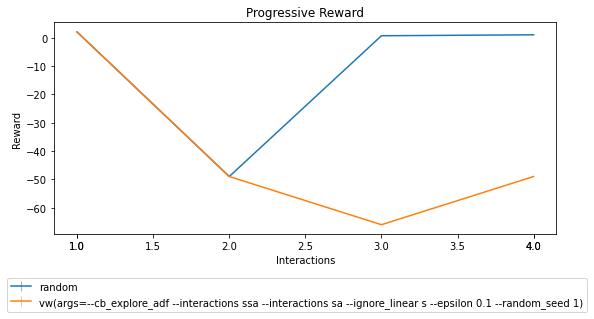

In [24]:
from coba.simulations import Interaction
from coba.learners    import RandomLearner, VowpalLearner
from coba.benchmarks  import Benchmark

class MySimulation:
    
    def read(self):
        yield Interaction(None, [1,2,3], [2,100,-100])
        yield Interaction(None, [1,2,3], [2,100,-100])
        yield Interaction(None, [1,2,3], [2,100,-100])
        yield Interaction(None, [1,2,3], [2,100,-100])
    
    def __repr__(self):
        return "MySimulation"

Benchmark([MySimulation()]).evaluate([RandomLearner(), VowpalLearner()]).plot_learners()